## Complete Logistic Regression with Ultrasonic Data

Importing all the libraries required

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import sys
import random
from scipy.optimize import minimize, rosen, rosen_der,fmin_cg

In [14]:
class unconstrained_optimizer:
    def __init__(self):
        return
    
    def Steepest_Gradient_Descent_Method(self,seed_theta,cost_fun,gradient_fun,epsilon,iter_max,in_param,alpha):
        
        next_theta=np.array(seed_theta)
        error_values=[]
        for i in range(iter_max):
            current_theta=next_theta
            #print(current_theta)
            current_grad_value=gradient_fun(current_theta,in_param)
            #print(current_grad_value)
            cost=cost_fun(current_theta,in_param)
            error_values.append(cost)
            criteria=np.linalg.norm(current_grad_value,2)/(1+np.absolute(cost))
            
            if criteria <= epsilon:
                print("Criteria of epsilon met at i:")
                print(i)
                return[current_theta,error_values]
            
            p=-current_grad_value
            next_theta=current_theta+(alpha*p)
        
        print("Maximum iteration reached.Criteria of epsilon not met")
        return[next_theta,error_values]
    
    def BFGS_Quasi_Newton_Method(self,seed_theta,seed_hessian,cost_fun,gradient_fun,epsilon,iter_max,in_param,alpha):
            next_theta=np.matrix(seed_theta).T
            next_B=np.matrix(seed_hessian)
            next_gradient=np.matrix(gradient_fun(next_theta,in_param)).T
            error_values=[]
            for i in range(iter_max):
                current_theta=next_theta
                current_B=next_B
                current_gradient=next_gradient
                cost=cost_fun(current_theta,in_param)
                error_values.append(cost)
                criteria=np.linalg.norm(current_gradient,2)/(1+np.absolute(cost))
                
                if criteria <= epsilon:
                    print("Criteria of epsilon met at i:")
                    print(i)
                    return[current_theta,error_values]
                
                #if np.linalg.det(current_B)<1e-5:
                #    print("Warning:B matrix is Singluar for the current estimate of X!!!!!")
                
                current_direction_value=np.linalg.lstsq(np.squeeze(np.asarray(current_B)),-1*np.squeeze(np.asarray(current_gradient)))[0]
                current_direction_value=np.matrix(current_direction_value).T
                next_theta=current_theta+(alpha*current_direction_value)
                next_gradient=np.matrix(gradient_fun(next_theta,in_param)).T
                s_k=next_theta-current_theta
                y_k=next_gradient-current_gradient
                next_B=current_B-((((current_B*s_k)*(current_B*s_k).T)/(s_k.T*current_B*s_k)))+((y_k*y_k.T)/(y_k.T*s_k))
            
            
            print("Maximum iteration reached.Criteria of epsilon not met")    
            return[next_theta,error_values]
        

In [15]:
## Function to normalize and create windowed data needed for training/validation/testing
# Depending on the Window size the data is extracted and each window is assigned with respective output
def data_creation(dwt_in,prediction,window_size=20):
    if window_size==1:
       sys.ext("window size should be greater than 1")
    feature_len=np.size(dwt_in)
    dwt_in=np.array(dwt_in)
    prediction=np.array(prediction)
    mu=np.mean(dwt_in)
    st_d=np.std(dwt_in)
    dwt_in=dwt_in-mu
    if st_d >0.01e-12:
        dwt_in=dwt_in/st_d

    new_mu=np.mean(dwt_in)
    dwt_in=np.append(new_mu*np.ones(window_size-1),dwt_in)    
    stack_prediction=np.array(np.matrix(prediction).T)
    stack_dwt=[]
    for i in range(feature_len):
        temp=dwt_in[i:i+window_size]
        temp=np.squeeze(np.asarray(np.fliplr(np.matrix(temp))))
        temp=np.power(temp,2)
        stack_dwt.append(temp)
            
    stack_dwt=np.array(stack_dwt)
    return[stack_dwt,stack_prediction]

In [16]:
## Limiting the output between 0 and 1 by use of sigmoid function
def sigmoid(z):
    g=np.matrix(np.zeros(np.shape(z)))
    g=1/(1+np.exp(-1*z))
    return g

def sigmoidGradient(z):
    a=sigmoid(z)
    g=np.multiply(a,(1-a))
    return g

## cost Function with regularization 
def randInitializeWeights(L_in, L_out):
    W = np.matrix(np.zeros((L_out, 1 + L_in)))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    W=np.matrix(W)
    return W

In [17]:
def nnCostFunction(nn_parms,in_param):
    input_layer_size=in_param[0]
    hidden_layer_size=in_param[1]
    num_labels=in_param[2]
    X=in_param[3]
    y=in_param[4]
    lamda=in_param[5]
    J=0
    d_point=((input_layer_size+1)*hidden_layer_size)
    T1=(((nn_parms[0:d_point]).T).reshape((input_layer_size+1,hidden_layer_size))).T
    d_point1=((hidden_layer_size+1)*num_labels)
    T2=(((nn_parms[d_point:d_point+d_point1]).T).reshape((hidden_layer_size+1,num_labels))).T
    (m,n)=np.shape(X)
    
    ## FeedForward Part
    a1=np.matrix(np.hstack((np.ones((m,1)),X)))
    z2=np.matmul(T1,a1.T)
    a2=sigmoid(z2)
    (m1,n1)=np.shape(a2)
    a2=np.matrix(np.vstack((np.ones((1,n1)),a2)))
    z3=np.matmul(T2,a2)
    a3=sigmoid(z3)
    
    
   
    for i in range(m):
        temp_y=np.zeros((num_labels,1))
        temp_y[int(np.asscalar(y[i])-1)]=1
        J=J+np.sum(np.multiply(-1*(temp_y),np.log(a3[:,i]))+np.multiply((-1*(1-temp_y)),np.log(1-a3[:,i])))
    
    J=J+( (lamda/2) * ( np.sum( np.power(T1[:,1:np.shape(T1)[1]] ,2) ) + np.sum( np.power(T2[:,1:np.shape(T2)[1]] ,2) ) ) )
    
    J=J/m
    return J

def nnGradFunction(nn_parms,in_param):
    input_layer_size=in_param[0]
    hidden_layer_size=in_param[1]
    num_labels=in_param[2]
    X=in_param[3]
    y=in_param[4]
    lamda=in_param[5]
    Grad=0
    d_point=((input_layer_size+1)*hidden_layer_size)
    T1=(((nn_parms[0:d_point]).T).reshape((input_layer_size+1,hidden_layer_size))).T
    d_point1=((hidden_layer_size+1)*num_labels)
    T2=(((nn_parms[d_point:d_point+d_point1]).T).reshape((hidden_layer_size+1,num_labels))).T
    (m,n)=np.shape(X)
    Theta1_grad = np.matrix(np.zeros(np.shape(T1)))
    Theta2_grad = np.matrix(np.zeros(np.shape(T2)))
    ## FeedForward Part
    a1=np.matrix(np.hstack((np.ones((m,1)),X)))
    z2=np.matmul(T1,a1.T)
    a2=sigmoid(z2)
    (m1,n1)=np.shape(a2)
    a2=np.matrix(np.vstack((np.ones((1,n1)),a2)))
    z3=np.matmul(T2,a2)
    a3=sigmoid(z3)
    

    for i in range(m):
        temp_y=np.zeros((num_labels,1))
        temp_y[int(np.asscalar(y[i])-1)]=1
        delta_3=a3[:,i]-temp_y
        #print(sigmoidGradient(np.vstack((np.ones((1,1)),z2[:,i]))))
        delta_2=np.multiply(np.matmul(T2.T,delta_3),sigmoidGradient(np.vstack((np.ones((1,1)),z2[:,i]))))
        delta_2=delta_2[1:np.shape(delta_2)[0]]
        Theta2_grad=Theta2_grad+np.matmul(delta_3,a2[:,i].T)
        Theta1_grad=Theta1_grad+np.matmul(delta_2,a1[i,:])
    Theta2_grad=Theta2_grad/m
    Theta1_grad=Theta1_grad/m
    
    temp_t1=np.matrix(np.zeros(np.shape(T1))+T1)
    temp_t2=np.matrix(np.zeros(np.shape(T2))+T2)
    (r,c)=np.shape(T2)
    temp_t2[:,0]=np.matrix(np.zeros((r,1)))
    Theta2_grad=Theta2_grad+((lamda/m)*temp_t2)
    (r,c)=np.shape(T1)
    temp_t1[:,0]=np.matrix(np.zeros((r,1)))
    Theta1_grad=Theta1_grad+((lamda/m)*temp_t1)
    
    Grad= np.matrix(np.hstack((Theta1_grad.flatten('F'),Theta2_grad.flatten('F')))) 
    return  np.squeeze(np.asarray(Grad))



def nnCostGradFunction(nn_parms,input_layer_size,hidden_layer_size,num_labels,X,y,lamda):
    J=0
    
    d_point=((input_layer_size+1)*hidden_layer_size)
    T1=(((nn_parms[0:d_point]).T).reshape((input_layer_size+1,hidden_layer_size))).T
    d_point1=((hidden_layer_size+1)*num_labels)
    T2=(((nn_parms[d_point:d_point+d_point1]).T).reshape((hidden_layer_size+1,num_labels))).T
    (m,n)=np.shape(X)
    Theta1_grad = np.matrix(np.zeros(np.shape(T1)))
    Theta2_grad = np.matrix(np.zeros(np.shape(T2)))
    
    ## FeedForward Part
    a1=np.matrix(np.hstack((np.ones((m,1)),X)))
    z2=np.matmul(T1,a1.T)
    a2=sigmoid(z2)
    (m1,n1)=np.shape(a2)
    a2=np.matrix(np.vstack((np.ones((1,n1)),a2)))
    z3=np.matmul(T2,a2)
    a3=sigmoid(z3)
    
    
    
    for i in range(m):
        temp_y=np.zeros((num_labels,1))
        temp_y[int(np.asscalar(y[i])-1)]=1
        J=J+np.sum(np.multiply(-1*(temp_y),np.log(a3[:,i]))+np.multiply((-1*(1-temp_y)),np.log(1-a3[:,i])))
        delta_3=a3[:,i]-temp_y
        delta_2=np.multiply(np.matmul(T2.T,delta_3),sigmoidGradient(np.vstack((np.ones((1,1)),z2[:,i]))))
        delta_2=delta_2[1:np.shape(delta_2)[0]]
        Theta2_grad=Theta2_grad+np.matmul(delta_3,a2[:,i].T)
        Theta1_grad=Theta1_grad+np.matmul(delta_2,a1[i,:])
        
    J=J+( (lamda/2) * ( np.sum( np.power(T1[:,1:np.shape(T1)[1]] ,2) ) + np.sum( np.power(T2[:,1:np.shape(T2)[1]] ,2) ) ) )
    
    J=J/m
    
    
    Theta2_grad=Theta2_grad/m
    Theta1_grad=Theta1_grad/m
    
    temp_t1=np.matrix(np.zeros(np.shape(T1))+T1)
    temp_t2=np.matrix(np.zeros(np.shape(T2))+T2)
    (r,c)=np.shape(T2)
    temp_t2[:,0]=np.matrix(np.zeros((r,1)))
    Theta2_grad=Theta2_grad+((lamda/m)*temp_t2)
    (r,c)=np.shape(T1)
    temp_t1[:,0]=np.matrix(np.zeros((r,1)))
    Theta1_grad=Theta1_grad+((lamda/m)*temp_t1)
       
    Grad= np.matrix(np.hstack((Theta1_grad.flatten('F'),Theta2_grad.flatten('F')))) 

    print(J)
    return J,Grad

In [18]:
input_layer_size  = 5
hidden_layer_size =3
num_labels = 2

file_path="/home/kushal/Desktop/Simulation/POC/Ultrasonic_dataset_14/generated_data/mar_22_rotate/DWT_Lev2/"
dwt_list=[]
annotation_list=[]
file_indices=[15,16,20,21,22,28,30,31,34,41,42,43,44,45,47,48,50,51,52,53,54,55,61,62,63,64,65,66,71,72,73,74,
                  75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,92,93,94,95,96,97,98,99,100,103,104,105,106,107,108,
                  109,110,111,112,113,114,115,116,117,118,119,124,125,126,127,128,129,130,136,137,138,139,
                  140,141,142,145,146,147,148,149,150,162,170,171,172,175,176,207,239,240]
rotate_by=[0,600,1000,1400,1700]

##Create File list 
for file_index in file_indices:
    for rotate in rotate_by:
        dwt_file_name="selected_mar22_dwt_l2_index_"+str(file_index)+"_rotate_"+str(rotate)+".dat"
        ann_file_name="annotation_dwt_l2_index_"+str(file_index)+"_rotate_"+str(rotate)+".dat"
        dwt_list.append(dwt_file_name)
        annotation_list.append(ann_file_name)
        



## Randomize file list
ind=[i for i in range(len(dwt_list))]
ind=np.array(random.sample(ind,len(ind)))
dwt_list=np.array(dwt_list)
dwt_list=dwt_list[ind]
annotation_list=np.array(annotation_list)
annotation_list=annotation_list[ind]
dwt_list=dwt_list.tolist()
annotation_list=annotation_list.tolist()


## Preparing first 100 A-scan dwts for training
initial_T1=randInitializeWeights(input_layer_size, hidden_layer_size)
initial_T2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_theta_bfgs=np.matrix(np.hstack((initial_T1.flatten('F'),initial_T2.flatten('F')))).T
itb=np.squeeze(np.asarray(initial_theta_bfgs))
optimize=unconstrained_optimizer()
initial_theta_cgd=initial_theta_bfgs
errors_bfgs=[]

for i in range(10):
    dwt_file=dwt_list[i]
    ann_file=annotation_list[i]
    dwt_in=np.loadtxt(file_path+dwt_file)
    ann_in=np.loadtxt(file_path+ann_file)
    [temp_in,temp_out]=data_creation(dwt_in[0],ann_in,window_size=input_layer_size)
    data_in=temp_in
    data_out=temp_out
    data_out=data_out+1    
    data_in=np.matrix(data_in)
    data_out=np.matrix(data_out)
    lamda=1
    in_param=[input_layer_size,hidden_layer_size,num_labels,data_in,data_out,lamda]
    [theta_bfgs,error_values_bfgs]=optimize.BFGS_Quasi_Newton_Method(itb,np.eye(len(itb)),nnCostFunction,nnGradFunction,1e-5,5000,in_param,0.5)
    #res = minimize(fun=nnCostFunction, x0=initial_theta_cgd, args=(in_param), method='CG', jac=nnGradFunction,tol=1e-6,options={'disp': True})
    #initial_theta_cgd=res.x
    errors_bfgs.append(np.array(error_values_bfgs))
    #errors_cgd.append(res.fun)
    itb=np.squeeze(np.asarray(theta_bfgs))
    

errors_cgd=[]
for i in range(10):
    dwt_file=dwt_list[i]
    ann_file=annotation_list[i]
    dwt_in=np.loadtxt(file_path+dwt_file)
    ann_in=np.loadtxt(file_path+ann_file)
    [temp_in,temp_out]=data_creation(dwt_in[0],ann_in,window_size=input_layer_size)
    data_in=temp_in
    data_out=temp_out
    data_out=data_out+1    
    data_in=np.matrix(data_in)
    data_out=np.matrix(data_out)
    lamda=1
    in_param=[input_layer_size,hidden_layer_size,num_labels,data_in,data_out,lamda]
    res = minimize(fun=nnCostFunction, x0=initial_theta_cgd, args=(in_param), method='CG', jac=nnGradFunction,tol=1e-6,options={'disp': True})
    initial_theta_cgd=res.x
    errors_cgd.append(res.fun)

#res=fmin_cg(f=nnCostFunction,x0=initial_theta,fprime=nnGradFunction,args=(input_layer_size, hidden_layer_size,num_labels,data_in,data_out,lamda),gtol=1e-6,maxiter=2000 ,disp= True)


/home/kushal/anaconda3/envs/JNN/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Criteria of epsilon met at i:
314
Criteria of epsilon met at i:
258


/home/kushal/anaconda3/envs/JNN/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Criteria of epsilon met at i:
361
Criteria of epsilon met at i:
236
Criteria of epsilon met at i:
140
Criteria of epsilon met at i:
138
Criteria of epsilon met at i:
342
Criteria of epsilon met at i:
274


/home/kushal/anaconda3/envs/JNN/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/home/kushal/anaconda3/envs/JNN/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


Criteria of epsilon met at i:
752
Criteria of epsilon met at i:
2025
Optimization terminated successfully.
         Current function value: 0.264000
         Iterations: 286
         Function evaluations: 806
         Gradient evaluations: 806
Optimization terminated successfully.
         Current function value: 0.239962
         Iterations: 281
         Function evaluations: 828
         Gradient evaluations: 828
Optimization terminated successfully.
         Current function value: 0.355772
         Iterations: 260
         Function evaluations: 776
         Gradient evaluations: 776
Optimization terminated successfully.
         Current function value: 0.198277
         Iterations: 141
         Function evaluations: 505
         Gradient evaluations: 505
Optimization terminated successfully.
         Current function value: 0.185794
         Iterations: 104
         Function evaluations: 334
         Gradient evaluations: 334
Optimization terminated successfully.
         Current f

Average Iterations for converegence:
485.0
variance
539.0204077769226
length of iteration:
0
Value of cost function:
1.4073563436971523
length of iteration:
315
Value of cost function:
0.26584309286966695
length of iteration:
574
Value of cost function:
0.24153251182061805
length of iteration:
936
Value of cost function:
0.3557715754089665
length of iteration:
1173
Value of cost function:
0.19827711357835118
length of iteration:
1314
Value of cost function:
0.18579375076975557
length of iteration:
1453
Value of cost function:
0.1882596451976607
length of iteration:
1796
Value of cost function:
0.19492769090309425
length of iteration:
2071
Value of cost function:
0.3316697760319101
length of iteration:
2824
Value of cost function:
0.2866297915363691
length of iteration:
4850
Value of cost function:
0.2765817727924242


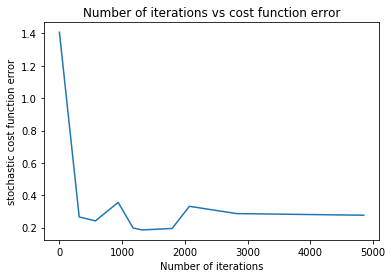

In [19]:
m_len=len(max(errors_bfgs,key=len))

stochastic_error_list=[]
number_of_iter=[]
for i in range(len(errors_bfgs)):
    tind=len(errors_bfgs[i])
    last=errors_bfgs[i][tind-1]
    lenth=m_len-tind
    stochastic_error_list.append(np.pad(errors_bfgs[i],(0,lenth),'edge'))
    number_of_iter.append(tind)
    
stochastic_error_list=np.array(stochastic_error_list)
ind=np.isnan(stochastic_error_list)
stochastic_error_list[ind]=0


#number_of_iter=np.array(number_of_iter)
#s_err=np.mean(stochastic_error_list,axis=0)
#threshold=np.mean(s_err)
#ind=np.where(s_err>threshold)
#s_err[ind]=threshold
#n_iter_bfgs=np.arange(len(s_err))
#plt.plot(n_iter_bfgs,s_err)
#plt.ylabel('Number of iterations')
#plt.xlabel('stochastic cost function error')
#plt.title('Number of iterations vs cost function error')
#plt.show()


print('Average Iterations for converegence:')
print(np.mean(number_of_iter))
print('variance')
print(np.std(number_of_iter))

x_val=[]
y_val=[]
ind=0
last_ind=0
print('length of iteration:')
print('0')
print('Value of cost function:')
print(errors_bfgs[0][0])
x_val.append(0)
y_val.append(errors_bfgs[0][0])
for i in range(len(errors_bfgs)):
    print('length of iteration:')
    ind=len(errors_bfgs[i])
    last_ind=ind+last_ind
    err_val=errors_bfgs[i][ind-1]
    print(last_ind)
    x_val.append(last_ind)
    print('Value of cost function:')
    print(err_val)
    y_val.append(err_val)

x_val=np.array(x_val)
y_val=np.array(y_val)

plt.plot(x_val,y_val)
plt.ylabel('stochastic cost function error')
plt.xlabel('Number of iterations')
plt.title('Number of iterations vs cost function error')
plt.show()

In [25]:
def predict(Theta1, Theta2, X):
    (m,n)=np.shape(X)
    p=np.matrix(np.zeros((m,1)))
    a1=np.matrix(np.hstack((np.ones((m,1)),X)))
    a2=sigmoid(np.matmul(Theta1,a1.T))
    (m1,n1)=np.shape(a2)
    a2=np.matrix(np.vstack((np.ones((1,n1)),a2)))
    a3=sigmoid(np.matmul(Theta2,a2))
    #pos_ind=np.where(a3[1,:]>=0.5)
    #a3[1,pos_ind]=1
    #neg_ind=np.where(a3[0,:]<0.5)
    #a3[0,pos_ind]=0
    return a3

def error(ref,prediction):
    ref=np.array(ref)
    prediction=np.array(prediction)
    pos_ind=np.where(prediction>=0.5)
    prediction[pos_ind]=1
    pos_ind=np.where(prediction<0.5)
    prediction[pos_ind]=0
    err=np.linalg.norm(prediction-ref,2)
    return err

def confusion_matrix(ref,prediction):
    ref=np.array(ref)
    prediction=np.array(prediction)
    pos_ind=np.where(prediction>=0.5)
    prediction[pos_ind]=1
    pos_ind=np.where(prediction<0.5)
    prediction[pos_ind]=0
    err=ref-prediction
    err.astype(int)
    false_alarms=np.sum(err==-1)/512
    miss=np.sum(err==1)/512
    return [false_alarms,miss]

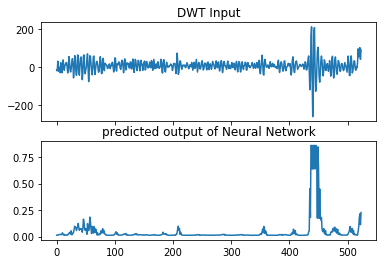

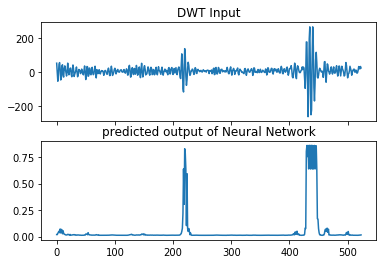

Avg RMS error per ascan:
4.289596265768024
Variance of RMS error per ascan:
1.0583696295704268
Avg cost error per ascan:
7.351524693904403
Variance of cost error per ascan:
0.41496016260096646
False Alarm:
0.0029702781173594132
Miss:
0.03515625


In [26]:
d_list=np.loadtxt("/home/kushal/Desktop/Simulation/POC/neuralnet/test_data_list.dat",dtype='str',delimiter=' ')
a_list=np.loadtxt("/home/kushal/Desktop/Simulation/POC/neuralnet/test_out_list.dat",dtype='str',delimiter=' ')

d_list=d_list.tolist()
a_list=a_list.tolist()

dwt_list=[]
ann_list=[]
for i in range(len(d_list)):
    dwt_list.append(d_list[i][0:len(d_list[i])])
    ann_list.append(a_list[i][0:len(a_list[i])])

FT=itb
dp=((input_layer_size+1)*hidden_layer_size)
FT1=(((FT[0:dp]).T).reshape((input_layer_size+1,hidden_layer_size))).T
dp1=((hidden_layer_size+1)*num_labels)
FT2=(((FT[dp:dp+dp1]).T).reshape((hidden_layer_size+1,num_labels))).T

j=0
ind_rms_ascan_err=[]
ind_cost_ascan_err=[]
ind_fa_ascan_err=[]
ind_miss_ascan_err=[]

for i in range(len(dwt_list)):
    dwt_file=dwt_list[i]
    ann_file=ann_list[i]
    dwt_in=np.loadtxt(file_path+dwt_file)
    ann_in=np.loadtxt(file_path+ann_file)
    [temp_in,temp_out]=data_creation(dwt_in[0],ann_in,window_size=input_layer_size)
    pr = predict(FT1, FT2, temp_in)
    pr1=np.squeeze(np.asarray(pr[0,:]))
    pr2=np.squeeze(np.asarray(pr[1,:]))
    x=np.arange(np.size(pr[0,:]))
    if j<2:
        f,axarr=plt.subplots(2,sharex=True)
        axarr[0].plot(x,dwt_in[0])
        axarr[0].set_title('DWT Input')
        #axarr[1].plot(x,temp_out)
        #axarr[1].set_title('Expected output')
        #axarr[2].plot(x,pr1)
        #axarr[2].set_title('predicted output')
        axarr[1].plot(x,pr2)
        axarr[1].set_title('predicted output of Neural Network')
        plt.show()
        j=j+1
    temp_out=np.squeeze(np.asarray(temp_out))
    lamda=1
    in_param=[input_layer_size,hidden_layer_size,num_labels,temp_in,temp_out,lamda]
    ind_cost_ascan_err.append(nnCostFunction(itb,in_param))
    ind_rms_ascan_err.append(error(temp_out,pr2))
    [tfa,tm]=confusion_matrix(temp_out,pr2)
    ind_fa_ascan_err.append(tfa)
    ind_miss_ascan_err.append(tm)

        

print("Avg RMS error per ascan:")
print(np.mean(np.array(ind_rms_ascan_err)))
print("Variance of RMS error per ascan:")
print(np.std(np.array(ind_rms_ascan_err)))

print("Avg cost error per ascan:")
print(np.mean(np.array(ind_cost_ascan_err)))
print("Variance of cost error per ascan:")
print(np.std(np.array(ind_cost_ascan_err)))

print("False Alarm:")
print(np.mean(np.array(ind_fa_ascan_err)))
print("Miss:")
print(np.mean(np.array(ind_miss_ascan_err)))